# Noise Model Based Heteroskedastic Bayesian neural net

*Prepared by Maxim Ziatdinov (November 2024)*

We typically assume a constant observation noise across all inputs by default. However, this assumption often fails in real-world datasets, where noise levels may depend on the input. In scientific experiments, domain experts may possess prior knowledge about how noise varies with inputs. NeuroBayes enables the integration of such knowledge through a noise model-based heteroskedastic Bayesian Neural Network (BNN). This approach leverages prior knoweldge about measurement noise levels to account for varying noise levels across different regions of the data, resulting in more accurate uncertainty quantification.

Imports:

In [ ]:
import sys
sys.path.append("..")

import neurobayes as nb

import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp

Define helper functions:

In [2]:
def toydata1d():

    x_start = 0
    x_stop = 4

    def f(x):
        return np.sin(3*(x-2)) + (x-2)**2

    return (x_start, x_stop), f

def noise_std(x):
    return 0.1 * np.exp(0.3 * x)

def measure(x, noise=True):
    y = toyfunc(x)
    if noise:
        y += np.random.randn(y.shape[0]) * noise_std(x)
    return y

Create toy dataset:

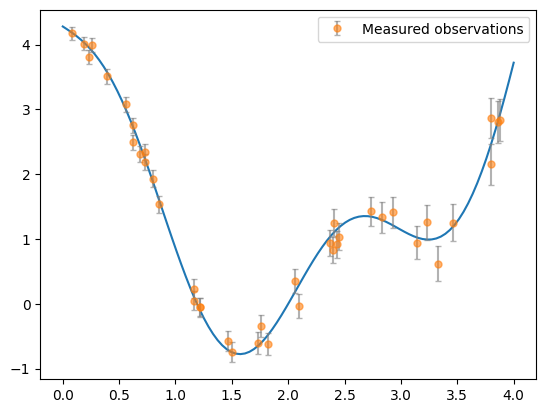

In [3]:
num_points = 40

(x_start, x_stop), toyfunc = toydata1d()

np.random.seed(42)

X_measured = np.random.uniform(x_start, x_stop, num_points)
y_measured = measure(X_measured)

X_domain = np.linspace(x_start, x_stop, 100)
y_true = measure(X_domain, noise=False)

plt.plot(X_domain, y_true)
plt.errorbar(X_measured, y_measured, yerr=noise_std(X_measured), fmt='o',
             markersize=5, ecolor='gray', capsize=2, label='Measured observations', alpha=0.6)
plt.legend()

Define a nosie model based on prior knowledge:

In [ ]:
def noise_model_fn(x, a, b):
    return a * jnp.exp(b*x)

noise_model = nb.utils.set_fn(noise_model_fn)
noise_model_prior = nb.priors.auto_normal_priors(noise_model_fn)

Train a noise model-based fully Bayesian heteroskedastic NN:

In [4]:
target_dim = 1
hidden_dims = [32, 16, 8]

architecture = nb.FlaxMLP(hidden_dims, target_dim)

bnn = nb.VarianceModelHeteroskedasticBNN(architecture, noise_model, noise_model_prior)
bnn.fit(X_measured, y_measured, num_warmup=1000, num_samples=1000)

sample: 100%|██████████| 2000/2000 [00:40<00:00, 49.53it/s, 1023 steps of size 1.48e-03. acc. prob=0.92]


Make prediction:

In [5]:
posterior_mean, posterior_var = bnn.predict(X_domain)

Plot results:

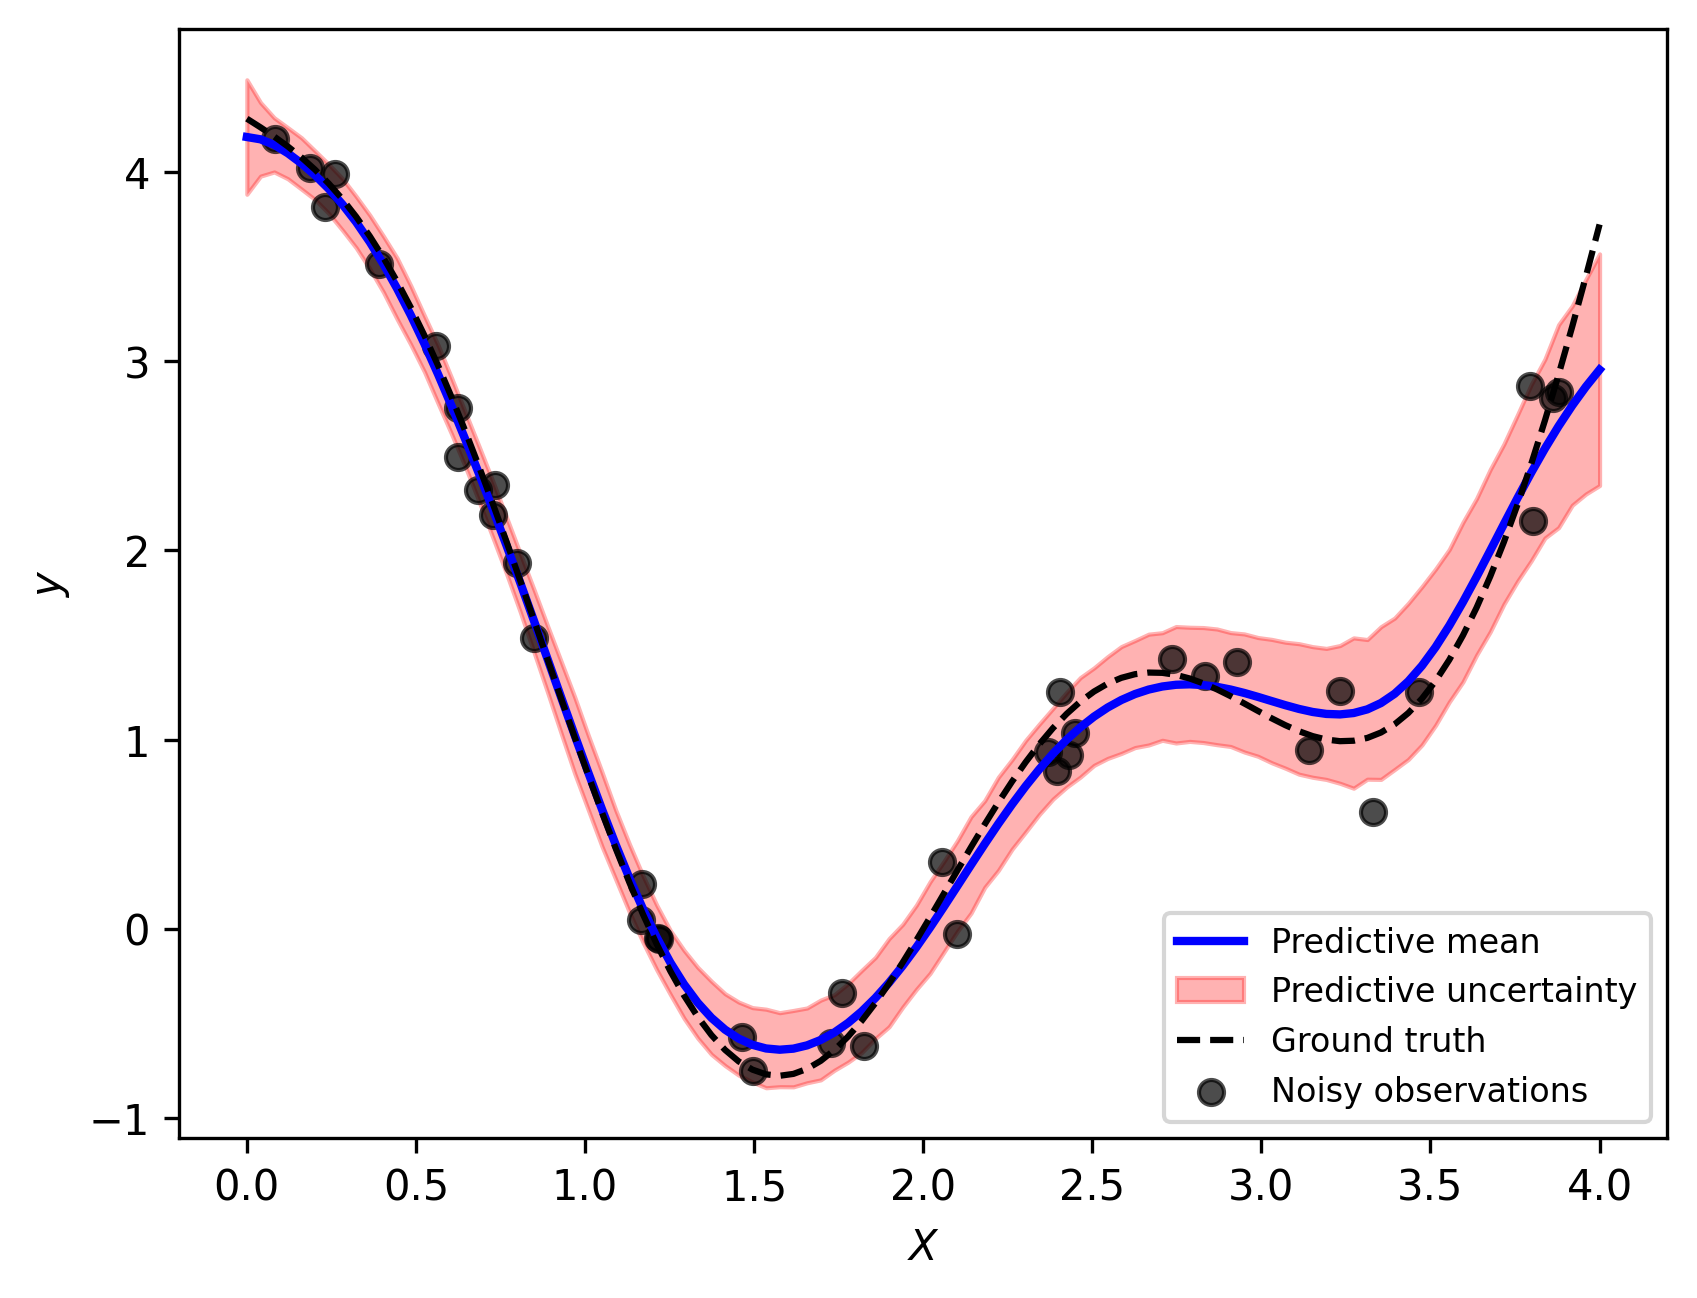

In [6]:
posterior_mean = posterior_mean.squeeze()
posterior_var = posterior_var.squeeze()

_, ax = plt.subplots(dpi=300)
ax.set_xlabel("$X$")
ax.set_ylabel("$y$")
ax.plot(X_domain, posterior_mean, lw=2.0,  c='blue', label='Predictive mean')
ax.fill_between(X_domain,
                posterior_mean - np.sqrt(posterior_var),
                posterior_mean + np.sqrt(posterior_var),
                color='r', alpha=0.3, label="Predictive uncertainty")
ax.plot(X_domain, y_true, '--', c='k', label='Ground truth')
ax.scatter(X_measured, y_measured, c='k', label="Noisy observations", alpha=0.7)
ax.legend(loc='best', fontsize=8)
plt.show()

We can also predict noise and compare it with actual noise in our data:

(0.0, 1.0)

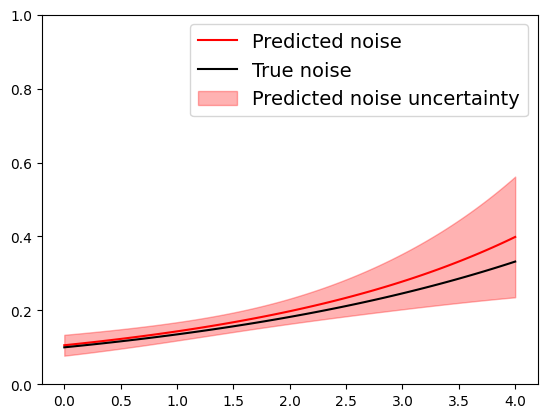

In [7]:
predicted_noise, predicted_noise_variance = bnn.predict_noise(X_domain)

predicted_noise = predicted_noise.squeeze()
predicted_noise_variance = predicted_noise_variance.squeeze()
plt.plot(X_domain, predicted_noise, color='r', label='Predicted noise')
plt.plot(X_domain, noise_std(X_domain), color='k', label='True noise')
plt.fill_between(
    X_domain,
    predicted_noise - np.sqrt(predicted_noise_variance),
    predicted_noise + np.sqrt(predicted_noise_variance),
    color='r', alpha=0.3, label="Predicted noise uncertainty")
plt.legend(fontsize=14)
plt.ylim(0, 1)

Let's do the same for a different noise dependency on input data:

In [8]:
def noise_std(x):
    return np.where(x > 2.0, 0.1, 0.4)

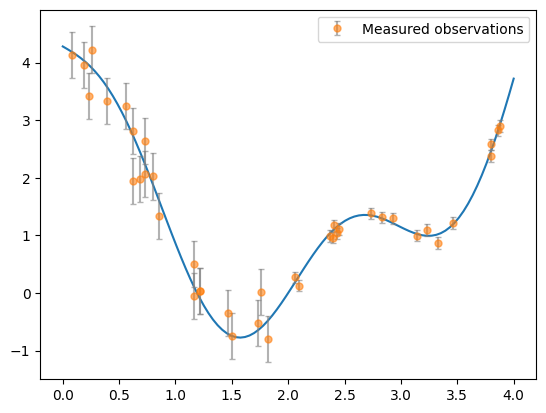

In [9]:
num_points = 40

(x_start, x_stop), toyfunc = toydata1d()

np.random.seed(42)

X_measured = np.random.uniform(x_start, x_stop, num_points)
y_measured = measure(X_measured)

X_domain = np.linspace(x_start, x_stop, 100)
y_true = measure(X_domain, noise=False)

plt.plot(X_domain, y_true)
plt.errorbar(X_measured, y_measured, yerr=noise_std(X_measured), fmt='o',
             markersize=5, ecolor='gray', capsize=2, label='Measured observations', alpha=0.6)
plt.legend()

Same as before, we create a nosie model bassed on our prior knowledge and train a noise model-based heteroskedastic Bayesian NN:

In [10]:
def noise_model_fn(x, t, low, high):
    return jnp.where(x > t, low, high)

noise_model = nb.utils.set_fn(noise_model_fn)
noise_model_prior = nb.priors.auto_lognormal_priors(noise_model_fn)


bnn = nb.VarianceModelHeteroskedasticBNN(architecture, noise_model, noise_model_prior)
bnn.fit(X_measured, y_measured, num_warmup=1000, num_samples=1000)

sample: 100%|██████████| 2000/2000 [00:34<00:00, 58.76it/s, 1023 steps of size 8.69e-04. acc. prob=0.81]


Make prediction:

In [11]:
posterior_mean, posterior_var = bnn.predict(X_domain)

Plot results:

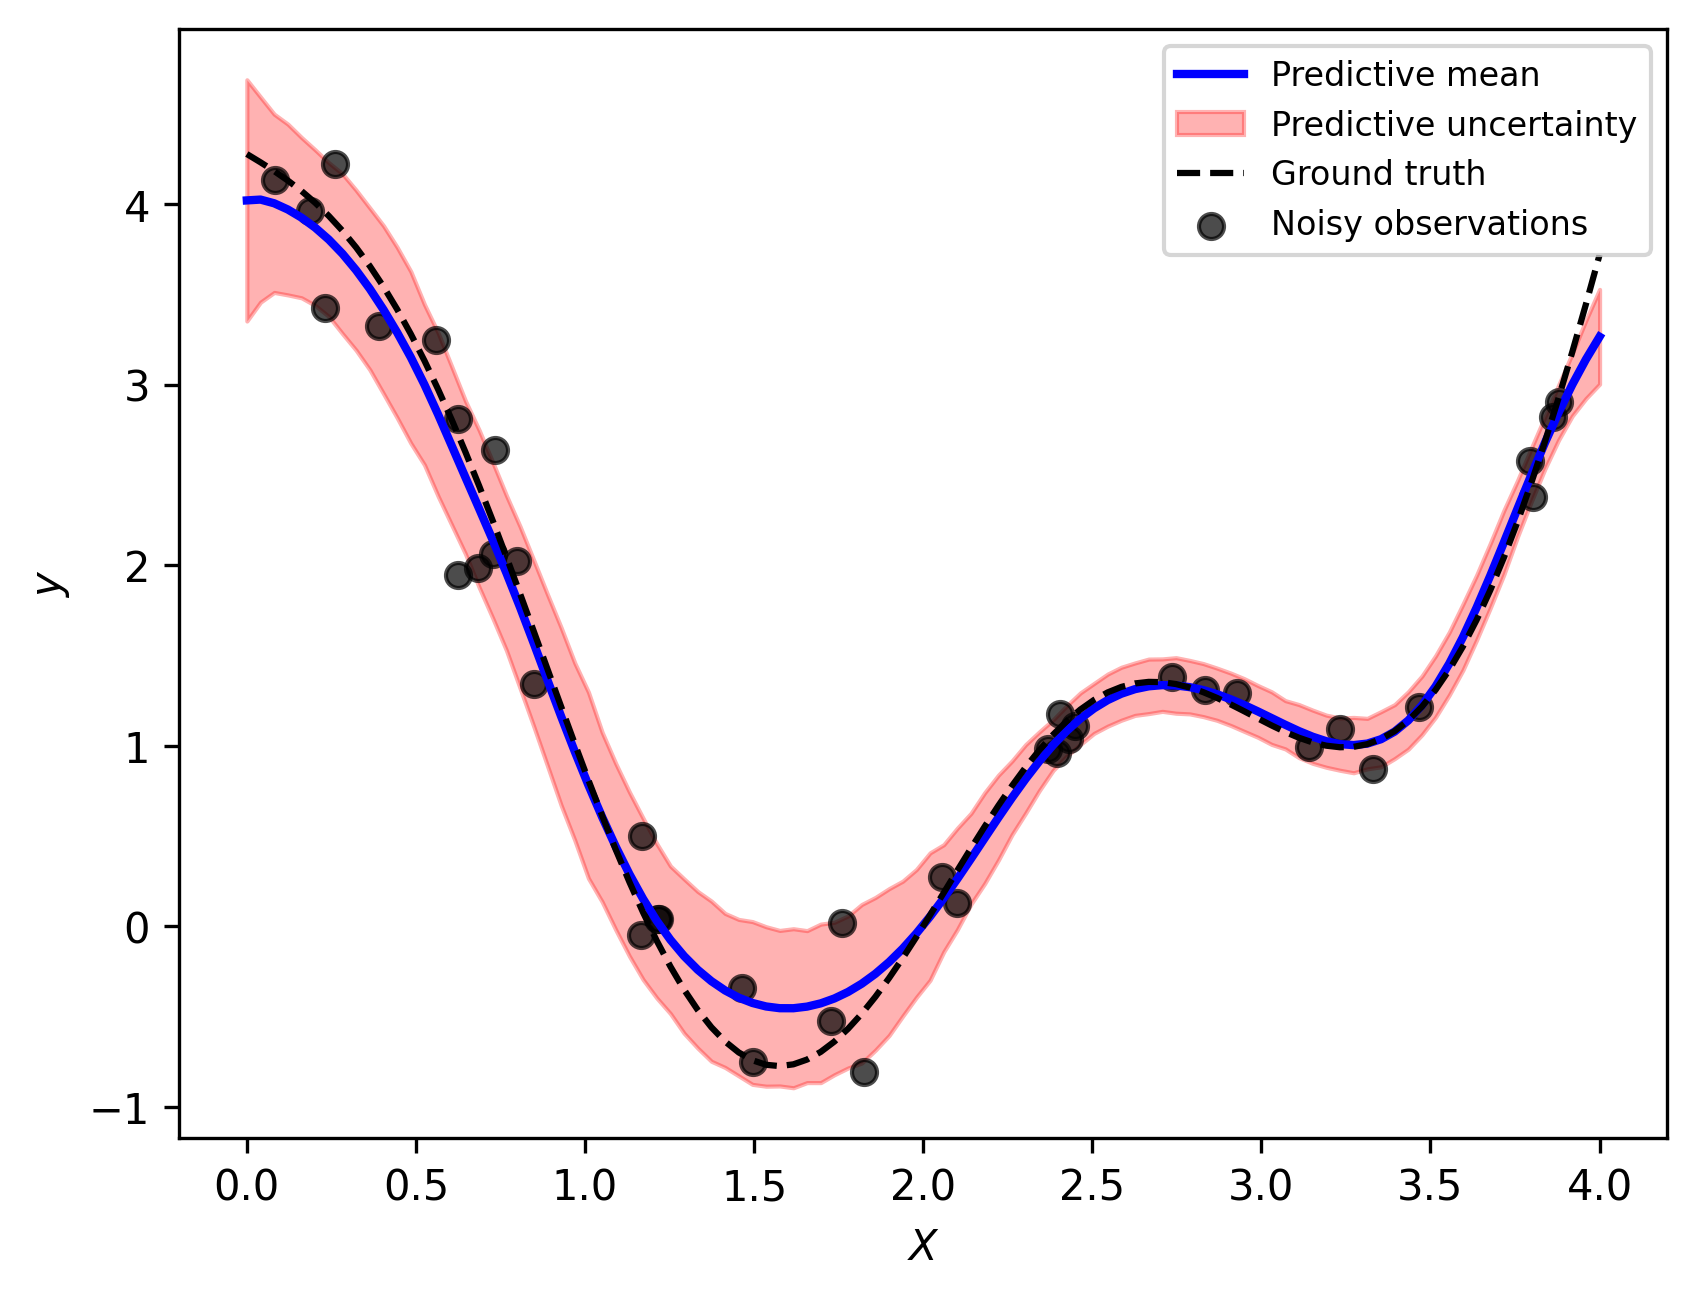

In [12]:
posterior_mean = posterior_mean.squeeze()
posterior_var = posterior_var.squeeze()

_, ax = plt.subplots(dpi=300)
ax.set_xlabel("$X$")
ax.set_ylabel("$y$")
ax.plot(X_domain, posterior_mean, lw=2.0,  c='blue', label='Predictive mean')
ax.fill_between(X_domain,
                posterior_mean - np.sqrt(posterior_var),
                posterior_mean + np.sqrt(posterior_var),
                color='r', alpha=0.3, label="Predictive uncertainty")
ax.plot(X_domain, y_true, '--', c='k', label='Ground truth')
ax.scatter(X_measured, y_measured, c='k', label="Noisy observations", alpha=0.7)
ax.legend(loc='best', fontsize=8)
plt.show()

Predict noise and compare it with actual noise in our data:

(0.0, 1.0)

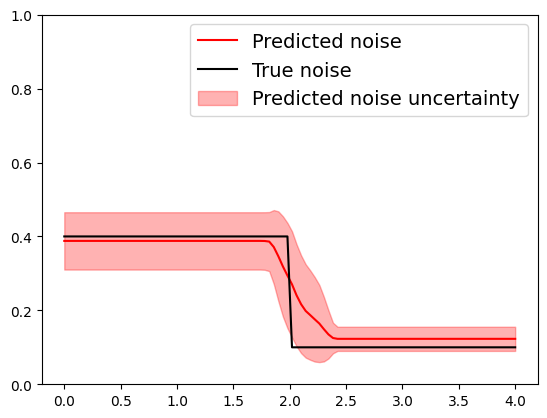

In [13]:
predicted_noise, predicted_noise_variance = bnn.predict_noise(X_domain)

predicted_noise = predicted_noise.squeeze()
predicted_noise_variance = predicted_noise_variance.squeeze()
plt.plot(X_domain, predicted_noise, color='r', label='Predicted noise')
plt.plot(X_domain, noise_std(X_domain), color='k', label='True noise')
plt.fill_between(
    X_domain,
    predicted_noise - np.sqrt(predicted_noise_variance),
    predicted_noise + np.sqrt(predicted_noise_variance),
    color='r', alpha=0.3, label="Predicted noise uncertainty")
plt.legend(fontsize=14)
plt.ylim(0, 1)